In [1]:
import tensorflow
import matplotlib.pyplot as plt
import scipy

ozellik_cikarici_model = tensorflow.keras.applications.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3) #image pixel boyutu, son sayı rgb
                  )

ozellik_cikarici_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [2]:
ozellik_cikarici_model.trainable = True
set_trainable = False
for layer in ozellik_cikarici_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

#oluşturduğumuz modelin ardışık olduğunu belirliyoruz. Sequential
model = tensorflow.keras.models.Sequential()
model.add(ozellik_cikarici_model)
model.add(tensorflow.keras.layers.Flatten())

#dense ile kendinden sonraki tüm noktalara bağlı olduğunu söylüyoruz
model.add(tensorflow.keras.layers.Dense(256,activation='relu'))#256 nöron sayısı
model.add(tensorflow.keras.layers.Dense(4,activation='softmax'))#4-çıktı sayısı,benim de zaten 4 sınıfım var

model.compile(loss='binary_crossentropy', # hata ölçme
              optimizer=tensorflow.keras.optimizers.RMSprop(lr=1e-5), # kendisini iyileşticeğei kısım
              metrics=['acc'])# performansda hangi metriğe bakacağını yazıyoruz

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,138,500
Trainable params: 13,503,236
Non-trainable params: 7,635,264
_________________________________________________________________


c:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [3]:
egitim_yolu = r'D:\projects\proje\dataSet\Train'
dogrulama_yolu = r'D:\projects\proje\dataSet\Validation'
test_yolu = r'D:\projects\proje\dataSet\Test'

# veri çoklama işleminin kurallarını belirledim
train_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255, # piksel değerleri 0-255'den 0-1 arasına getiriliyor.
      rotation_range=40, # resmi 40 derece döndürme
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip = False, #burası önemli, aynalama 
      fill_mode='nearest'
      )

train_generator = train_datagen.flow_from_directory(
        egitim_yolu,
        target_size=(224, 224),
        batch_size=16, #veriyi aynı anda verme sayısı 
        )

# To validate the training process, we do not need augmented images.
validation_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255
        )

validation_generator = validation_datagen.flow_from_directory(
        dogrulama_yolu,
        target_size=(224, 224),
        batch_size=16,
        )

Found 1151 images belonging to 4 classes.
Found 92 images belonging to 4 classes.


In [4]:
class MyThresholdCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, acc_limit,val_limit):
        super(MyThresholdCallback, self).__init__()
        self.acc_limit = acc_limit
        self.val_limit = val_limit
    def on_epoch_end(self, epoch, logs=None): 
        acc = logs["acc"]
        val_acc = logs["val_acc"]
        if val_acc >= self.val_limit :
            if acc >= self.acc_limit :
                self.model.stop_training = True

callbacks = MyThresholdCallback(acc_limit=0.99, val_limit=0.99)

In [36]:
#eğitim takibi
history = model.fit( 
      train_generator,
      steps_per_epoch=15,
      epochs=250,
      validation_data=validation_generator,
      validation_steps=1,
      callbacks=[callbacks]
      )



Epoch 1/300
15/15 [==============================] - 60s 4s/step - loss: 0.5895 - acc: 0.2343 - val_loss: 0.5256 - val_acc: 0.3750
Epoch 2/300
15/15 [==============================] - 66s 4s/step - loss: 0.5566 - acc: 0.3125 - val_loss: 0.5412 - val_acc: 0.4375
Epoch 3/300
15/15 [==============================] - 59s 4s/step - loss: 0.5452 - acc: 0.3458 - val_loss: 0.5155 - val_acc: 0.5000
Epoch 4/300
15/15 [==============================] - 59s 4s/step - loss: 0.5347 - acc: 0.3542 - val_loss: 0.5021 - val_acc: 0.4375
Epoch 5/300
15/15 [==============================] - 59s 4s/step - loss: 0.5267 - acc: 0.4142 - val_loss: 0.5165 - val_acc: 0.5000
Epoch 6/300
15/15 [==============================] - 59s 4s/step - loss: 0.5235 - acc: 0.4250 - val_loss: 0.5386 - val_acc: 0.4375
Epoch 7/300
15/15 [==============================] - 60s 4s/step - loss: 0.5175 - acc: 0.4142 - val_loss: 0.5067 - val_acc: 0.3125
Epoch 8/300
15/15 [==============================] - 61s 4s/step - loss: 0.5004 - a

In [37]:
model.save('D:/projects/proje/modeller/Model5.h5')

test_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255
        )

test_generator = test_datagen.flow_from_directory(
       test_yolu,
        target_size=(224, 224),
        batch_size=20,
        )

Found 290 images belonging to 4 classes.


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


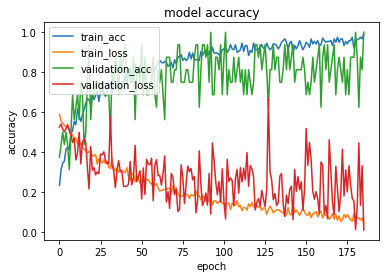

C:\Users\SAHILR~1\AppData\Local\Temp/ipykernel_6312/1567553234.py:14: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)


test acc: 0.8413792848587036


In [38]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'train_loss', 'validation_acc', 'validation_loss'], loc='upper left')
plt.show()

# Printing the test results.
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)